# Dog Breed Classification Using Transfer Learning

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [3]:
# Install smdebug
!pip install smdebug

In [4]:
# Import packages
import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)


from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from sagemaker.pytorch import PyTorch

import smdebug
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from markupsafe import Markup

from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import IPython


[2022-04-28 09:45:58.891 ip-172-16-30-72:18410 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [4]:
sagemaker.get_execution_role()

'arn:aws:iam::700919767769:role/service-role/AmazonSageMaker-ExecutionRole-20220423T222358'

## Dataset
The dog breed classification dataset provided by Udacity has been used here. The dataset contains images from 133 dog breeds divided into training, testing and validation datasets.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!unzip dogImages.zip -d dataset/

In [8]:
#!ls /root/'Deep Learning Project'/dataset

dogImages  dogImages.zip


In [10]:
#!aws s3 cp /root/'Deep Learning Project'/dataset s3://image-classification-dog-breed --recursive

upload: ../dataset/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://image-classification-dog-breed/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: ../dataset/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://image-classification-dog-breed/dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg
upload: ../dataset/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://image-classification-dog-breed/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: ../dataset/dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://image-classification-dog-breed/dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg
upload: ../dataset/dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg to s3://image-classification-dog-breed/dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg
upload: ../dataset/dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg to s3://image-classification-dog-breed/dogImages/test/001.Affenp

## Hyperparameter Tuning

In this part a resnet18 pretrained model has been used to perform hyperparameter tuning - such that it the best hyperparameters are determined for the predictor model. 
The hyperparameters being tuned are:

1) Learning rate    --> Continuous parameter with values tuned between 0.001 and 0,1

2) Batch size       --> Categorical parameter with specific list of trial values

3) Number of epochs --> Integer parameter between 1 and 2(inclusive)

The training and testing script in `hpo.py` is used to perform hyperparameter tuning.

In [6]:
# Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(1, 2)
}

# The objective metric to be used by the Hyperparameter Tuning jobs is the Test Accuracy of the model on the validation dataset

objective_metric_name = "Accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Accuracy", "Regex": "Test set: Accuracy: ([0-9\\.]+)%"}]


In [8]:
# Create estimators for HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=sagemaker.get_execution_role(),
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.2xlarge"
)

# Configuring the estimated to run 6 total hyperparameter tuner jobs with a allowed parallel job count of 2

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=6,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [ ]:

inputs_train = 's3://image-classification-dog-breed/dogImages/train/'
inputs_test = 's3://image-classification-dog-breed/dogImages/test/'

tuner.fit({"training": inputs_train,"test":inputs_test})


.....................................................................................................................................................................................................................................................

In [11]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-04-27 21:05:25 Starting - Preparing the instances for training
2022-04-27 21:05:25 Downloading - Downloading input data
2022-04-27 21:05:25 Training - Training image download completed. Training in progress.
2022-04-27 21:05:25 Uploading - Uploading generated training model
2022-04-27 21:05:25 Completed - Training job completed


{'_tuning_objective_metric': '"Accuracy"',
 'batch-size': '"128"',
 'epochs': '2',
 'lr': '0.036756477351601646',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-04-27-20-31-24-050"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-700919767769/pytorch-training-2022-04-27-20-31-24-050/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

Using the attach method of the HyperparameterTuner class to retrieve the job details(as I had taken a pause and shutdown the notebook after the tuning job ran)

In [5]:
attach_tuner = HyperparameterTuner.attach("pytorch-training-220427-2031")

In [6]:
attach_tuner.best_estimator().hyperparameters()


2022-04-27 21:05:25 Starting - Preparing the instances for training
2022-04-27 21:05:25 Downloading - Downloading input data
2022-04-27 21:05:25 Training - Training image download completed. Training in progress.
2022-04-27 21:05:25 Uploading - Uploading generated training model
2022-04-27 21:05:25 Completed - Training job completed


{'_tuning_objective_metric': '"Accuracy"',
 'batch-size': '"128"',
 'epochs': '2',
 'lr': '0.036756477351601646',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-04-27-20-31-24-050"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-700919767769/pytorch-training-2022-04-27-20-31-24-050/source/sourcedir.tar.gz"'}

The optimum hyperparameters being determined by the tuning job are:

1) Learning rate    --> 0.036756477351601646

2) Batch size       --> 128

3) Number of epochs --> 2


In [10]:
rule_configs.vanishing_gradient()

{'DebugRuleConfiguration': {'RuleConfigurationName': 'VanishingGradient',
  'RuleParameters': {'rule_to_invoke': 'VanishingGradient'}},
 'CollectionConfigurations': [{'CollectionName': 'gradients',
   'CollectionParameters': {'save_interval': '500'}}]}

In [28]:
# Debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"include_regex": "CrossEntropyLoss_output_0","train.save_interval": "100", "eval.save_interval": "10"}
)


In [29]:
debugger_config.hook_parameters

{'include_regex': 'CrossEntropyLoss_output_0',
 'train.save_interval': '100',
 'eval.save_interval': '10'}

In [30]:
hyperparameters = attach_tuner.best_estimator().hyperparameters()


2022-04-27 21:05:25 Starting - Preparing the instances for training
2022-04-27 21:05:25 Downloading - Downloading input data
2022-04-27 21:05:25 Training - Training image download completed. Training in progress.
2022-04-27 21:05:25 Uploading - Uploading generated training model
2022-04-27 21:05:25 Completed - Training job completed


-----------------------------------------------------------------------------------------------------
#### The best hyperparameters json retrieved from the tuning job contains the batch_size as a string.
#### The PyTorch estimator expects the batch-size in an integer variable.

#### Stripping the quotes on batch-size value for compatibility with PyTorch

In [31]:
hyperparameters['batch-size']=hyperparameters['batch-size'].replace("\"", '')
hyperparameters

{'_tuning_objective_metric': '"Accuracy"',
 'batch-size': '128',
 'epochs': '2',
 'lr': '0.036756477351601646',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-04-27-20-31-24-050"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-700919767769/pytorch-training-2022-04-27-20-31-24-050/source/sourcedir.tar.gz"'}

------------------------------------------------------------------------------------------------------------------------
#### Tweaking the hyperparameters as the above best hyperparameters gave a lower accuracy after PyTorch training below.

##### This could be because the hyperparameter tuning job potentially needed from trials to determine the best HPs

In [41]:
hyperparameters['batch-size']='32'
hyperparameters['epochs']='4'

hyperparameters

{'_tuning_objective_metric': '"Accuracy"',
 'batch-size': '32',
 'epochs': '4',
 'lr': '0.036756477351601646',
 'sagemaker_container_log_level': 20,
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': 'pytorch-training-2022-04-28-11-20-34-302',
 'sagemaker_program': 'train_model.py',
 'sagemaker_region': 'us-east-1',
 'sagemaker_submit_directory': 's3://sagemaker-us-east-1-700919767769/pytorch-training-2022-04-28-11-20-34-302/source/sourcedir.tar.gz'}

In [42]:
# Create and fit an estimator


estimator_debug = PyTorch(
    entry_point="train_model.py",
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [43]:
inputs_train = 's3://image-classification-dog-breed/dogImages/train/'
inputs_test = 's3://image-classification-dog-breed/dogImages/test/'

estimator_debug.fit({"training": inputs_train,"test":inputs_test}, wait=True)

2022-04-28 11:44:10 Starting - Starting the training job...LossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2022-04-28 11:45:03 Starting - Preparing the instances for training......
2022-04-28 11:46:03 Downloading - Downloading input data.........
2022-04-28 11:47:28 Training - Downloading the training image....................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-28 11:50:57,320 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-04-28 11:50:57,344 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-28 11:50:57,353 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-04-28 11:50:57,959 sagemaker-training-toolkit INFO     Invoking user sc

In [44]:
# Print the name of the latest training job for the PyTorch estimator
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator_debug.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2022-04-28-11-44-09-907
Region: us-east-1


In [35]:
estimator_debug.latest_job_debugger_artifacts_path()

's3://sagemaker-us-east-1-700919767769/pytorch-training-2022-04-28-11-20-34-302/debug-output'

In [45]:
# Plotting the debugging output.
trial = create_trial(estimator_debug.latest_job_debugger_artifacts_path())

trial.tensor_names()


[2022-04-28 11:59:39.205 ip-172-16-30-72:18410 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-700919767769/pytorch-training-2022-04-28-11-44-09-907/debug-output
[2022-04-28 11:59:40.043 ip-172-16-30-72:18410 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-04-28 11:59:41.068 ip-172-16-30-72:18410 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [46]:
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))


9
9


In [48]:
# Helper methods to plot the captured debugging output

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


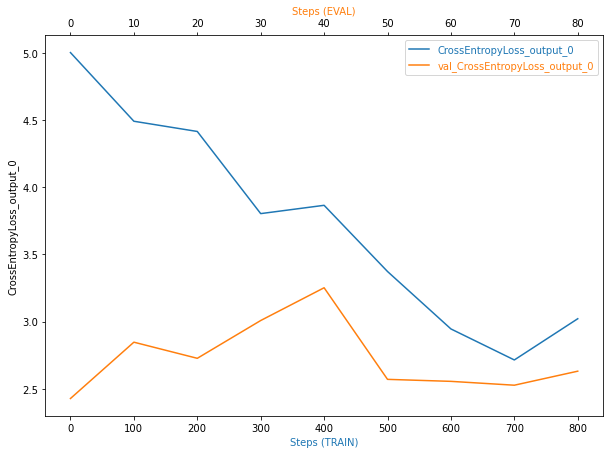

In [49]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [50]:
# Display the profiler output
tj = TrainingJob(training_job_name, region)

# Check if profiler processing is complete and reports are available
tj.wait_for_sys_profiling_data_to_be_available()


ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-700919767769/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-700919767769/pytorch-training-2022-04-28-11-44-09-907/profiler-output


Profiler data from system is available


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [51]:
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

In [52]:
view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-04-28 12:05:31.178 ip-172-16-30-72:18410 INFO metrics_reader_base.py:134] Getting 13 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1'}


In [55]:
rule_output_path = estimator_debug.output_path + estimator_debug.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-700919767769/pytorch-training-2022-04-28-11-44-09-907/rule-output


In [56]:
# Download the profiler report output
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2022-04-28 11:58:22     423651 pytorch-training-2022-04-28-11-44-09-907/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-04-28 11:58:22     280102 pytorch-training-2022-04-28-11-44-09-907/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-04-28 11:58:17        546 pytorch-training-2022-04-28-11-44-09-907/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-04-28 11:58:17      32137 pytorch-training-2022-04-28-11-44-09-907/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-04-28 11:58:17       2005 pytorch-training-2022-04-28-11-44-09-907/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-04-28 11:58:17        130 pytorch-training-2022-04-28-11-44-09-907/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-04-28 11:58:17       8505 pytorch-training-2022-04-28-11-44-09-907/rule-output/ProfilerReport/profiler-output/profiler-re

In [59]:
from sagemaker.debugger import Rule

In [61]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator_debug.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [63]:
profiler_report_name

'ProfilerReport'

In [62]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [68]:
estimator_debug.latest_training_job.job_name

'pytorch-training-2022-04-28-11-44-09-907'

In [67]:
sagemaker_session = sagemaker.session.Session()
sagemaker_session.default_bucket() 

'sagemaker-us-east-1-700919767769'

In [87]:
estimator_debug